In [232]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp

tickers = [
    "AAPL", "NVDA", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "^SPX", "AVGO", "TSLA",
    "LLY", "WMT", "JPM", "V", "XOM", "MA", "UNH", "ORCL", "COST", "PG",
    "NFLX", "JNJ", "ABBV", "HD", "BAC", "KO", "TMUS", "CVX", "CRM", "CSCO",
    "MRK", "PM", "WFC", "IBM", "ABT", "LIN", "MCD", "GE", "PEP", "PLTR",
    "ACN", "TMO", "T", "AXP", "MS", "VZ", "DIS", "GS", "RTX", "NOW",
    "QCOM", "ISRG", "ADBE", "BX", "AMGN", "INTU", "PGR", "AMD", "CAT", "TXN",
    "DHR", "NEE", "UBER", "SPGI", "BKNG", "PFE", "BLK", "BSX", "UNP", "SYK",
    "SCHW", "GILD", "HON", "CMCSA", "VRTX", "C", "DE", "TJX", "AMAT", "COP",
    "LOW", "BA", "PANW", "FI", "MDT", "BMY", "ADP", "CB", "ETN", "MMC",
    "MU", "SBUX", "LMT", "NKE", "PLD", "ANET", "INTC", "ADI", "LRCX", "KKR"
]


In [233]:
inc = yf.download(tickers, period='5y')
t = yf.download(tickers= '^TYX', period='5y')

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  1 of 1 completed


In [234]:
inc = inc['Close']
t = t['Close']


In [235]:
rets = np.log(inc / inc.shift(1))
t = t/365
rets.drop(rets.index[0], inplace=True)
t.drop(t.index[0], inplace=True)  # Drops first row
t.drop(t.index[0], inplace=True)
t = t.reset_index()
rets = rets.reset_index()
rets = rets[rets.index < 252]
rf_rate =t[t.index < 252]['^TYX'].values

In [236]:
excess_returns = rets.merge(t, on = 'Date')
rets.drop(['Date'], axis = 1, inplace = True)
# didnt need excess returns as they are alread accounted for in the aclculation of sharpe, as we take into account the market premium
rf_rate =np.log(rf_rate +1)
# excess_returns.iloc[:, 1:-1] = excess_returns.iloc[:, 1:-1].sub(excess_returns["^TYX"], axis=0)

In [237]:
excess_returns.drop(['^TYX', 'Date'], axis = 1, inplace= True)

In [238]:
cov_matrix = rets.cov().values

In [239]:
mu = rets.mean(axis=0).values.reshape(-1, 1)
num_assets = rets.shape[1]
weights = cp.Variable(num_assets)

In [240]:
target_return = cp.Parameter()

portfolio_return = mu.T @ weights
portfolio_variance = cp.quad_form(weights, cov_matrix)

problem = cp.Problem(
    cp.Minimize(portfolio_variance),
    [portfolio_return >= target_return, cp.sum(weights) == 1, weights >= 0, weights <= 0.3]
)

the constraint on the individual weights was eyeballed

In [241]:
import numpy as np

target_returns = np.linspace(np.percentile(mu, 10), np.percentile(mu,90), 200)
efficient_portfolios = []

for ret in target_returns:
    target_return.value = ret
    problem.solve()
    
    status = problem.status
    if status in ["optimal", "optimal_inaccurate"]:
        efficient_portfolios.append({
            'return': ret,
            'volatility': np.sqrt(portfolio_variance.value),
            'weights': weights.value
        })
    else:
        print(f"Problem could not be solved for return {ret}. Status: {status}")

In [242]:
np.percentile(mu,90)
np.percentile(mu,10)


0.0007727119823080791

In [243]:
weights_market = np.full(100, 0.01)
market_variance = np.dot(weights_market.T, np.dot(cov_matrix, weights_market))

sharpe_ratios = [(p['return'] - rf_rate.mean()) / p['volatility'] for p in efficient_portfolios]
tangency_portfolio = efficient_portfolios[np.argmax(sharpe_ratios)]

return_port = [rf_rate.mean() + (p['return'] - rf_rate.mean()) * market_variance / p['volatility'] for p in efficient_portfolios]

max_index = np.argmax(return_port)

if max_index < len(efficient_portfolios):
    tangency_portfolio_ = efficient_portfolios[max_index]
else:
    print(f"Error: Index {max_index} is out of range for list with length {len(efficient_portfolios)}")
    
    

In [244]:
np.dot(rets, weights_market).sum() -np.log(rf_rate+1).mean()

# out market return
market_variance
len(rets)
np.argmax(return_port)

199

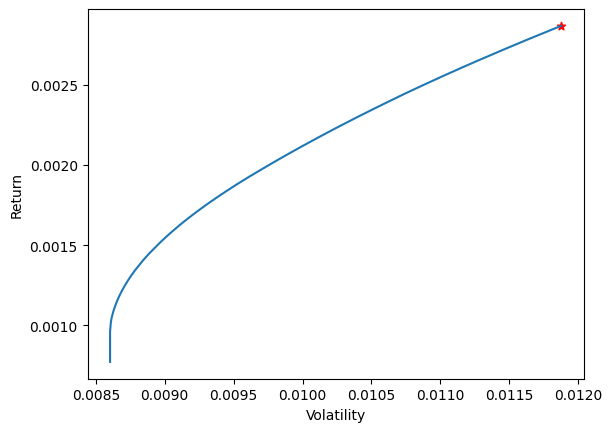

In [245]:
import matplotlib.pyplot as plt

plt.plot([p['volatility'] for p in efficient_portfolios], [p['return'] for p in efficient_portfolios])
plt.scatter(tangency_portfolio_['volatility'], tangency_portfolio_['return'], color='red', marker='*')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [246]:
weights_port = tangency_portfolio_['weights']
weights_port.max()

0.2510589611733539

In [247]:
rets_test = np.log(inc / inc.shift(1))
rets_test.drop(rets_test.index[0], inplace=True)
rets_test = rets_test.reset_index()
rets_test = rets_test[rets_test.index >= 252]
rets_test.drop(['Date'], axis = 1, inplace = True)


In [248]:
np.exp(np.dot(weights_port, rets_test.sum()/4))
# 5 years gives 14% annual return with no fees

1.132444070538753

In [249]:
weights_market = np.full(100, 0.01)
current_rets = rets
weights_series = tangency_portfolio_['weights']

for ret in rets_test.values:
    
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])
    cov_matrix_updated = np.cov(current_rets, rowvar=False)
    
    market_variance = np.dot(tangency_portfolio_['weights'].T, np.dot(cov_matrix, tangency_portfolio_['weights']))
    
    return_port = [np.log(rf_rate+1).mean() + (p['return'] - np.log(rf_rate+1).mean()) * market_variance / p['volatility'] for p in efficient_portfolios]
    max_index = np.argmax(return_port)
    
    if max_index < len(efficient_portfolios):
        tangency_portfolio_ = efficient_portfolios[max_index]
        # You could use tangency_portfolio['weights'] here if you want to completely replace weights

    weights_series = np.vstack((weights_series, (tangency_portfolio_['weights'])))

In [ ]:
def recalculate_markowitz_weights(current_rets, rf_rate, weights_var, target_return_param):
    """
    Recalculate the Markowitz model and return the optimal weights.
    
    Parameters:
    -----------
    current_rets : numpy.ndarray
        Current returns data
    rf_rate : float or numpy.ndarray
        Risk-free rate
    weights_var : cvxpy.Variable
        CVXPY variable for weights
    target_return_param : cvxpy.Parameter
        CVXPY parameter for target return

    Returns:
    --------
    numpy.ndarray
        Optimal portfolio weights
    """
    mu = current_rets.values.mean(axis=0).reshape(-1, 1)
    
    cov_matrix = np.cov(current_rets, rowvar=False)
    
    portfolio_return = mu.T @ weights_var
    portfolio_variance = cp.quad_form(weights_var, cov_matrix)
    
    problem = cp.Problem(
        cp.Minimize(portfolio_variance),
        [portfolio_return >= target_return_param, cp.sum(weights_var) == 1, weights_var >= 0, weights_var <= 0.3]
    )
    
    target_returns = np.linspace(np.percentile(mu, 10), np.percentile(mu, 90), 100)
    efficient_portfolios = []
    
    for ret in target_returns:
        target_return_param.value = ret
        problem.solve()
        
        status = problem.status
        if status in ["optimal", "optimal_inaccurate"]:
            efficient_portfolios.append({
                'return': ret,
                'volatility': np.sqrt(portfolio_variance.value),
                'weights': weights_var.value
            })
    
    if efficient_portfolios:
        rf_mean = np.mean(rf_rate)
        sharpe_ratios = [(p['return'] - rf_mean) / p['volatility'] for p in efficient_portfolios]
        max_index = np.argmax(sharpe_ratios)
        if max_index < len(efficient_portfolios):
            return efficient_portfolios[max_index]['weights']
    
    return np.full(current_rets.shape[1], 1/current_rets.shape[1])


In [254]:

weights_market = np.full(100, 0.01)
updated_weights = []
current_rets = rets.copy()
current_rf_rate = rf_rate[-1]
rf_rate_test = np.log(t[t.index >= 252]['^TYX'].values + 1)
weights = cp.Variable(current_rets.shape[1])
target_return = cp.Parameter(nonneg=True)

initial_weights = recalculate_markowitz_weights(
    current_rets, 
    current_rf_rate, 
    weights, 
    target_return
)
updated_weights.append(initial_weights.copy())

for i, ret in enumerate(rets_test.values):
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])
    if i > 0 and i % 10 == 0:
        print(f"Markowitz model at step {i}")
        optimal_weights = recalculate_markowitz_weights(
            current_rets, 
            rf_rate_test[i], 
            # need to make sure that the data for the rate comes in at the same time
            weights, 
            target_return
        )
        updated_weights.append(optimal_weights.copy())
    else:
        # Use the most recent weights
        updated_weights.append(updated_weights[-1].copy())


ValueError: Quadratic form matrices must be symmetric/Hermitian.

In [266]:
mu = current_rets.values.mean(axis=0).reshape(-1, 1)
mu

array([[ 0.00262219],
       [ 0.00159931],
       [ 0.00171934],
       [ 0.00214858],
       [ 0.00159241],
       [ 0.00225119],
       [ 0.0013662 ],
       [ 0.00429476],
       [ 0.00216598],
       [ 0.00092228],
       [ 0.00183256],
       [ 0.00158363],
       [ 0.00280264],
       [ 0.00207464],
       [ 0.00212412],
       [ 0.00248105],
       [ 0.00217924],
       [ 0.00223112],
       [ 0.000649  ],
       [ 0.00067188],
       [ 0.00210038],
       [ 0.00233312],
       [ 0.00285809],
       [ 0.00146384],
       [ 0.00186137],
       [ 0.00231617],
       [ 0.0009771 ],
       [ 0.00153293],
       [ 0.00122506],
       [ 0.00169228],
       [ 0.00400825],
       [ 0.00194422],
       [ 0.00256817],
       [ 0.00236519],
       [ 0.00089559],
       [ 0.00201505],
       [-0.00041169],
       [ 0.0022859 ],
       [ 0.0022771 ],
       [ 0.00305876],
       [ 0.00204155],
       [ 0.00200804],
       [ 0.00094208],
       [ 0.00076738],
       [ 0.00205295],
       [ 0

In [ ]:
for i, ret in enumerate(rets_test.values):
    print(i, ret)

SyntaxError: cannot assign to expression (1375014507.py, line 1)

In [ ]:
for ret in rets_test.values:
    print(ret.reshape(1, -1))
    current_rets = np.vstack([current_rets, ret.reshape(1, -1)])

[[ 0.00693462  0.00276842 -0.00753853  0.0075371   0.01662689  0.03360477
   0.00492217  0.05759071  0.03246098  0.00144584  0.02139788  0.02016691
   0.02616129  0.02188814 -0.00693351  0.02046623  0.02233402  0.01692573
  -0.00317315 -0.00181276  0.00881677  0.00534641  0.00374509  0.00643594
   0.01175848  0.01962849  0.00695487  0.03181956  0.00520764  0.00911951
  -0.0054136   0.          0.0238303   0.00871265  0.02595392  0.01135937
   0.02762076  0.03286722  0.03209024  0.00195525  0.00815659 -0.00124439
  -0.00022521  0.00855705  0.03127623  0.01165131 -0.00929181  0.00967537
   0.03024404 -0.00380162  0.00249573 -0.0084933   0.00410503  0.00597629
   0.07140906  0.02015789  0.00476263  0.0005077   0.01392504  0.01102283
   0.          0.00718522  0.0275261   0.04651488  0.00211393  0.03347847
  -0.00271264  0.0137027   0.03413451  0.02310266  0.01842817 -0.00120254
   0.00193029 -0.00852773 -0.00062774  0.02331108 -0.00949106 -0.00769242
   0.03846884  0.00012933  0.00100609 

In [ ]:
current_rets.view()

array([[-5.40518362e-02, -3.70339263e-02, -3.01025484e-02,
        -5.39857499e-02, -5.49981169e-02, -6.40259233e-02,
        -5.22641244e-02, -5.65679377e-02, -4.08403112e-02,
        -2.45679239e-02, -2.17874228e-02, -4.94889941e-02,
        -5.84894643e-02, -9.51468502e-02, -1.31980861e-01,
        -7.12498998e-02, -5.63324705e-02, -7.16719867e-02,
        -1.66429942e-02, -7.77213819e-02, -1.10567515e-01,
        -8.96043953e-02, -4.12566689e-02, -6.97030573e-02,
        -5.86994107e-02, -3.90649847e-02,  5.77036436e-03,
        -7.13870394e-02, -2.52463168e-02, -5.53252008e-02,
        -3.30384416e-02, -7.27362860e-02, -1.75442396e-02,
        -6.03508926e-02, -7.63211318e-02, -1.20305170e-01,
        -3.05586633e-02, -5.04332894e-02, -5.28822283e-02,
        -6.20447508e-02, -4.42399107e-02, -3.09701477e-02,
        -5.36064430e-02, -4.22704908e-02, -5.30339458e-02,
        -7.75452961e-02, -1.78508395e-02, -6.50499339e-02,
        -6.83238427e-02, -4.93326249e-02, -7.26951055e-0

In [ ]:
rets

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,...,UBER,UNH,UNP,V,VRTX,VZ,WFC,WMT,XOM,^SPX
0,-0.054052,-0.037034,-0.030103,-0.053986,-0.054998,-0.064026,-0.052264,-0.056568,-0.040840,-0.024568,...,-0.093807,-0.049568,-0.032792,-0.050992,-0.053829,-0.015190,-0.077114,0.004566,-0.011656,-0.045146
1,0.016549,0.023024,0.036797,0.010227,0.009088,0.042035,0.014009,-0.001387,0.018832,0.054453,...,-0.070905,0.013061,0.038166,0.027570,0.071367,0.043087,0.024169,0.038752,0.073689,0.022573
2,-0.014476,-0.023705,0.000126,-0.026718,-0.034644,-0.013084,-0.022913,-0.022452,-0.043645,-0.016752,...,-0.036993,-0.046611,-0.023042,-0.035834,-0.016026,-0.010005,-0.037048,0.006971,-0.029898,-0.015253
3,0.083640,0.031659,0.040454,0.087422,0.083346,0.101425,0.082666,0.087583,0.109531,0.029595,...,0.130075,0.078939,0.064822,0.109606,0.068867,0.035910,0.087552,0.053688,0.031629,0.067968
4,-0.011650,-0.004500,-0.009717,-0.011691,-0.032484,0.004686,-0.019450,0.030095,0.000841,-0.013322,...,-0.009666,-0.001209,-0.014236,-0.005029,-0.030342,0.004926,0.004878,-0.032898,0.018848,-0.001604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.004155,0.007925,0.008689,0.003954,-0.001152,-0.003596,0.009294,-0.011461,-0.003405,0.003173,...,0.024799,0.001321,0.014872,-0.000481,0.003869,0.006469,0.030485,0.006739,-0.002844,0.005227
248,0.005128,0.020014,0.025051,0.044275,0.039349,0.046978,0.029974,0.071862,0.015492,0.026489,...,0.015102,0.014420,0.031118,0.026383,0.010679,0.013846,0.011637,0.008323,0.026870,0.016494
249,0.001484,0.007052,0.001310,-0.004390,0.000490,-0.020968,-0.000987,-0.023040,-0.003494,0.008271,...,-0.025173,0.006829,0.000269,0.004579,0.009598,0.011110,-0.033763,0.011332,-0.005386,-0.000868
250,-0.012350,0.000562,-0.020498,-0.003548,-0.008259,-0.008092,-0.024240,0.008318,-0.014889,-0.020646,...,0.002060,-0.014616,-0.008331,-0.012242,-0.017315,-0.004088,0.024413,-0.006828,-0.012447,-0.003163
